In [2]:
# Cell 1: Import necessary libraries
import os
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping
from keras.callbacks import  ModelCheckpoint
from tensorflow.keras import regularizers
import matplotlib.pyplot as plt
from keras.applications import InceptionV3

In [7]:
# Cell 2: Define constants
BATCH_SIZE = 16
IMG_HEIGHT = 224
IMG_WIDTH = 224
DATA_DIR = "/home/anon/MajorProject/Data/Dataset_alpha"

In [8]:
# Cell 3: Load data

# # train and test if already separated
# TRAIN_DATA_DIR = "/home/anon/MajorProject/Data/Synthetic_Dataset/train"
# TEST_DATA_DIR = "/home/anon/MajorProject/Data/Synthetic_Dataset/test"

# train_ds = tf.keras.utils.image_dataset_from_directory(
#     TRAIN_DATA_DIR,
#     image_size=(IMG_HEIGHT, IMG_WIDTH),
#     batch_size=BATCH_SIZE)

# val_ds = tf.keras.utils.image_dataset_from_directory(
#     TEST_DATA_DIR,
#     image_size=(IMG_HEIGHT, IMG_WIDTH),
#     batch_size=BATCH_SIZE)


train_ds = tf.keras.utils.image_dataset_from_directory(
    DATA_DIR,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE)

val_ds = tf.keras.utils.image_dataset_from_directory(
    DATA_DIR,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE)

class_names = train_ds.class_names
num_classes = len(class_names)
print(class_names)

Found 1500 files belonging to 15 classes.
Using 1200 files for training.
Found 1500 files belonging to 15 classes.
Using 300 files for validation.
['Brightness_Decrease', 'Brightness_Increase', 'Chrome_Open', 'Cursor_Movement', 'Double_Click', 'Initiation', 'Left_Click', 'Nothing', 'PowerPoint_Open', 'Right_Click', 'Screenshot', 'Scroll', 'Shutdown', 'Volume_Decrease', 'Volume_Increase']


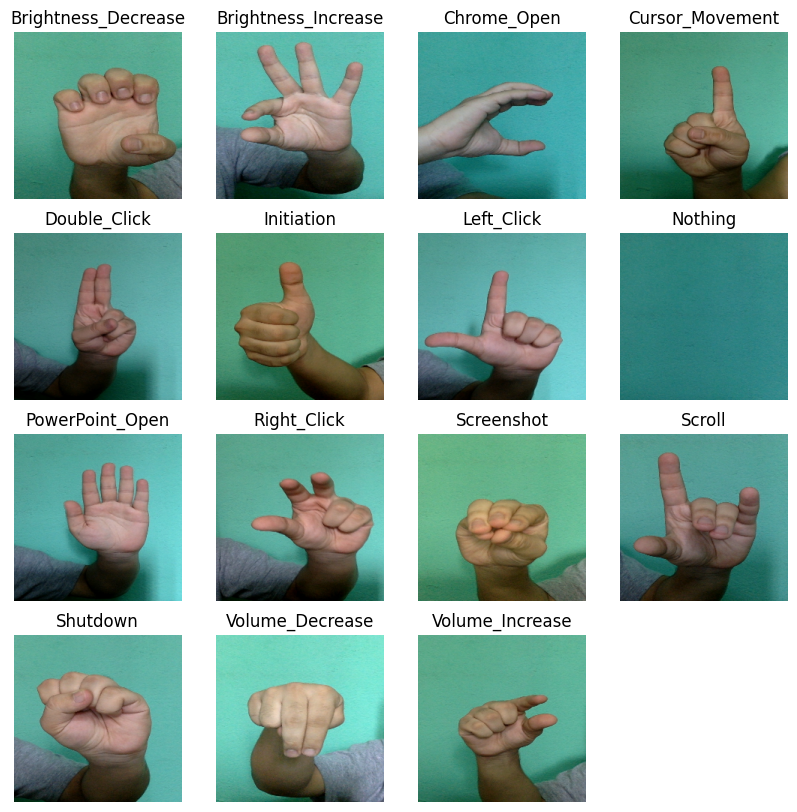

In [9]:
import math

# Calculate the number of rows and columns for the grid
num_rows = math.ceil(math.sqrt(num_classes))
num_cols = num_rows

plt.figure(figsize=(10, 10))

# Create a dictionary to store an image from each class
class_images = {class_name: None for class_name in class_names}

# Iterate over the batches
for images, labels in train_ds:
  # Iterate over the images and labels in the current batch
  for image, label in zip(images, labels):
    # If we haven't stored an image for this class yet, store it
    if class_images[class_names[label]] is None:
      class_images[class_names[label]] = image

  # If we've stored an image for each class, stop iterating over the batches
  if all(image is not None for image in class_images.values()):
    break

# Plot an image for each class
for i, class_name in enumerate(class_names):
  ax = plt.subplot(num_rows, num_cols, i + 1)
  plt.imshow(class_images[class_name].numpy().astype("uint8"))
  plt.title(class_name)
  plt.axis("off")



In [6]:
# Before data augmentation
for images, labels in train_ds.take(1):
  for image in images:
    print(image.shape)


(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)


In [11]:
# Cell 4: Define data augmentation
data_augmentation = keras.Sequential(
    [
        # layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.05),
        layers.RandomZoom(0.1),
        # layers.RandomContrast(0.1),
        layers.RandomBrightness(0.1),
        # layers.RandomWidth(0.1),
        layers.RandomCrop(IMG_HEIGHT, IMG_HEIGHT),
    ]
)

In [12]:
# Cell 5: Preprocess data #data augmentation and one hot encoding
# train_ds = train_ds.map(lambda x, y: (tf.map_fn(lambda img: tf.squeeze(data_augmentation(tf.expand_dims(img, 0)), axis=0), x), tf.one_hot(y, num_classes)))
# val_ds = val_ds.map(lambda x, y: (tf.map_fn(lambda img: tf.squeeze(data_augmentation(tf.expand_dims(img, 0)), axis=0), x), tf.one_hot(y, num_classes)))


#no one hot encoding since class > 10:
# data augmentation
train_ds = train_ds.map(lambda x, y: (tf.map_fn(lambda img: tf.squeeze(data_augmentation(tf.expand_dims(img, 0)), axis=0), x), y))
val_ds = val_ds.map(lambda x, y: (x, y))

In [38]:
# After data augmentation
for images, labels in train_ds.map(lambda x, y: (tf.map_fn(lambda img: tf.squeeze(data_augmentation(tf.expand_dims(img, 0)), axis=0), x), y)).take(1):
    for image in images:
        print(image.shape)

(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)


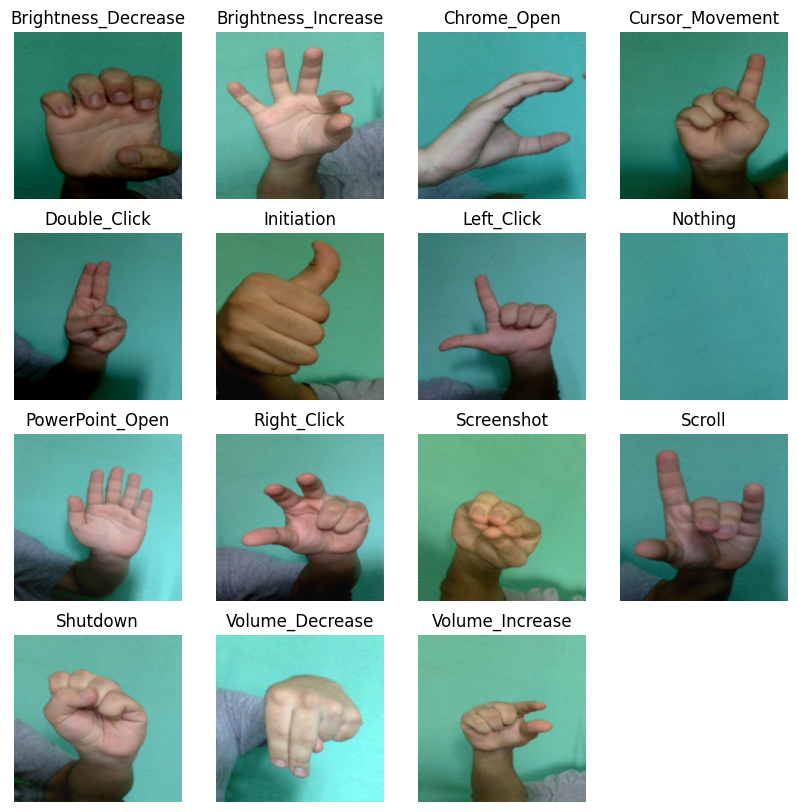

In [13]:
import math

# Calculate the number of rows and columns for the grid
num_rows = math.ceil(math.sqrt(num_classes))
num_cols = num_rows

plt.figure(figsize=(10, 10))

# Create a dictionary to store an image from each class
class_images = {class_name: None for class_name in class_names}

# Iterate over the batches
for images, labels in train_ds:
  # Apply data augmentation
  augmented_images = tf.map_fn(lambda img: tf.squeeze(data_augmentation(tf.expand_dims(img, 0)), axis=0), images)
  
  # Iterate over the images and labels in the current batch
  for image, label in zip(augmented_images, labels):
    # If we haven't stored an image for this class yet, store it
    if class_images[class_names[label]] is None:
      class_images[class_names[label]] = image

  # If we've stored an image for each class, stop iterating over the batches
  if all(image is not None for image in class_images.values()):
    break

# Plot an image for each class
for i, class_name in enumerate(class_names):
  ax = plt.subplot(num_rows, num_cols, i + 1)
  plt.imshow(class_images[class_name].numpy().astype("uint8"))
  plt.title(class_name)
  plt.axis("off")


In [17]:
# Cell 6: Build model
inputs = layers.Input(shape=(IMG_WIDTH, IMG_HEIGHT, 3))
base_model = InceptionV3(include_top=False,weights="imagenet")

# add a global spatial average pooling layer
x = base_model.output
x = layers.GlobalAveragePooling2D()(x)
# let's add a fully-connected layer
x = layers.Dense(1024, activation='relu')(x)
# and a logistic layer -- let's say we have num_classes classes
predictions = layers.Dense(num_classes, activation='softmax')(x)

# this is the model we will train
model = keras.Model(inputs=base_model.input, outputs=predictions,name ="InceptionV3")

# first: train only the top layers (which were randomly initialized)
# i.e. freeze all convolutional InceptionV3 layers
for layer in base_model.layers:
    layer.trainable = False

model.compile(optimizer='rmsprop', loss="sparse_categorical_crossentropy", metrics=["accuracy","SparseCategoricalAccuracy", "SparseTopKCategoricalAccuracy"])

In [18]:
for images, labels in train_ds.take(1):
    print(f'Training images shape: {images.shape}, labels shape: {labels.shape}')

for images, labels in val_ds.take(1):
    print(f'Validation images shape: {images.shape}, labels shape: {labels.shape}')


Training images shape: (16, 224, 224, 3), labels shape: (16,)
Validation images shape: (16, 224, 224, 3), labels shape: (16,)


In [19]:
print(model.summary())

Model: "InceptionV3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_4 (InputLayer)        [(None, None, None, 3)]      0         []                            
                                                                                                  
 conv2d_94 (Conv2D)          (None, None, None, 32)       864       ['input_4[0][0]']             
                                                                                                  
 batch_normalization_94 (Ba  (None, None, None, 32)       96        ['conv2d_94[0][0]']           
 tchNormalization)                                                                                
                                                                                                  
 activation_94 (Activation)  (None, None, None, 32)       0         ['batch_normalizatio

In [20]:
# Cell 7: Define callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
checkpoint_filepath = '/home/anon/MajorProject/Non_Git/Checkpoints/Dataset_alpha/checkpoint-{epoch:02d}-{val_accuracy:.4f}.keras'
model_checkpoint = ModelCheckpoint(filepath=checkpoint_filepath, monitor='val_accuracy', mode='max', save_best_only=True)

In [21]:
#Cell 8 train the model
epochs = 40
hist = model.fit(train_ds, epochs=epochs, validation_data=val_ds, callbacks=[early_stopping, model_checkpoint])

Epoch 1/40


2024-02-14 13:00:04.957003: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8904


 4/75 [>.............................] - ETA: 1s - loss: 100.5135 - accuracy: 0.1250 - sparse_categorical_accuracy: 0.1250 - sparse_top_k_categorical_accuracy: 0.6094 

2024-02-14 13:00:06.601632: I external/local_xla/xla/service/service.cc:168] XLA service 0x7f0f1492c2b0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-02-14 13:00:06.601653: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 4080, Compute Capability 8.9
2024-02-14 13:00:06.608819: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1707894906.640590    1995 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


75/75 [==============================] - 8s 52ms/step - loss: 42.1119 - accuracy: 0.2108 - sparse_categorical_accuracy: 0.2108 - sparse_top_k_categorical_accuracy: 0.5667 - val_loss: 6.4376 - val_accuracy: 0.3467 - val_sparse_categorical_accuracy: 0.3467 - val_sparse_top_k_categorical_accuracy: 0.6833
Epoch 2/40
75/75 [==============================] - 2s 24ms/step - loss: 6.8954 - accuracy: 0.3483 - sparse_categorical_accuracy: 0.3483 - sparse_top_k_categorical_accuracy: 0.7025 - val_loss: 5.8847 - val_accuracy: 0.2867 - val_sparse_categorical_accuracy: 0.2867 - val_sparse_top_k_categorical_accuracy: 0.7667
Epoch 3/40
75/75 [==============================] - 2s 30ms/step - loss: 3.8405 - accuracy: 0.4600 - sparse_categorical_accuracy: 0.4600 - sparse_top_k_categorical_accuracy: 0.8267 - val_loss: 2.8464 - val_accuracy: 0.4733 - val_sparse_categorical_accuracy: 0.4733 - val_sparse_top_k_categorical_accuracy: 0.8900
Epoch 4/40
75/75 [==============================] - 2s 29ms/step - loss

In [22]:
# Cell 10: Save the model
model.save('/home/anon/MajorProject/Non_Git/Models/Inception_224x224_FEB_14_Dataset_alpha.keras')

In [23]:
#for categorical_crossentropy
# import numpy as np

# # Initialize lists to store the true and predicted labels
# y_true = []
# y_pred = []

# # Iterate over the validation dataset
# for images, labels in val_ds:
#     # Get the model's predictions
#     pred_probs = model.predict(images)

#     # Convert the predicted probabilities to class labels
#     preds = np.argmax(pred_probs, axis=1)

#     # Convert one-hot encoded labels back to class labels
#     labels = np.argmax(labels.numpy(), axis=1)

#     # Append the labels to the lists
#     y_true.extend(labels)
#     y_pred.extend(preds)

# # Convert the lists to numpy arrays
# y_true = np.array(y_true)
# y_pred = np.array(y_pred)


#for sparse_categorical_crossentropy
import numpy as np

# Initialize lists to store the true and predicted labels
y_true = []
y_pred = []

# Iterate over the validation dataset
for images, labels in val_ds:
    # Get the model's predictions
    pred_probs = model.predict(images)

    # Convert the predicted probabilities to class labels
    preds = np.argmax(pred_probs, axis=1)

    # Append the labels to the lists
    y_true.extend(labels.numpy())
    y_pred.extend(preds)

# Convert the lists to numpy arrays
y_true = np.array(y_true)
y_pred = np.array(y_pred)


1/1 [==============================] - 0s 14ms/step


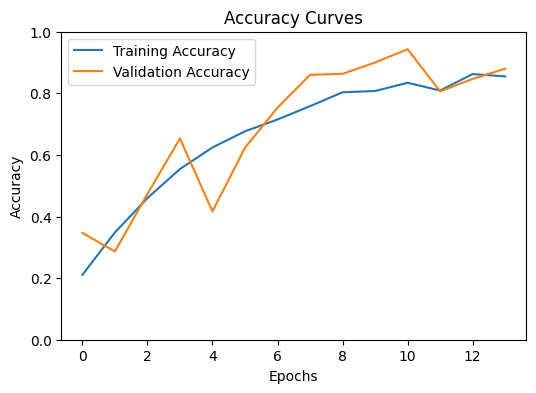

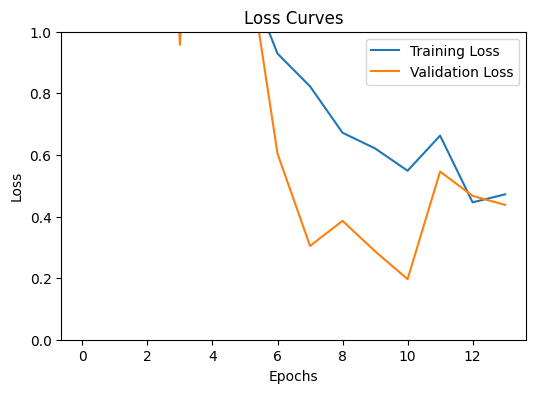

In [24]:
import matplotlib.pyplot as plt

# Plotting the Accuracy Curve
plt.figure(figsize=[6,4])
plt.plot(hist.history['accuracy'], linewidth=1.5)
plt.plot(hist.history['val_accuracy'], linewidth=1.5)
plt.legend(['Training Accuracy', 'Validation Accuracy'])
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy Curves')
plt.ylim([0, 1])  # Set the limits of the y-axis here
plt.show()

# Plotting the Loss Curve
plt.figure(figsize=[6,4])
plt.plot(hist.history['loss'], linewidth=1.5)
plt.plot(hist.history['val_loss'], linewidth=1.5)
plt.legend(['Training Loss', 'Validation Loss'])
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Curves')
plt.ylim([0, 1])  # Set the limits of the y-axis here
plt.show()


In [25]:
# let's visualize layer names and layer indices to see how many layers
# we should freeze:
for i, layer in enumerate(model.layers):
   print(i, layer.name)

0 input_4
1 conv2d_94
2 batch_normalization_94
3 activation_94
4 conv2d_95
5 batch_normalization_95
6 activation_95
7 conv2d_96
8 batch_normalization_96
9 activation_96
10 max_pooling2d_4
11 conv2d_97
12 batch_normalization_97
13 activation_97
14 conv2d_98
15 batch_normalization_98
16 activation_98
17 max_pooling2d_5
18 conv2d_102
19 batch_normalization_102
20 activation_102
21 conv2d_100
22 conv2d_103
23 batch_normalization_100
24 batch_normalization_103
25 activation_100
26 activation_103
27 average_pooling2d_9
28 conv2d_99
29 conv2d_101
30 conv2d_104
31 conv2d_105
32 batch_normalization_99
33 batch_normalization_101
34 batch_normalization_104
35 batch_normalization_105
36 activation_99
37 activation_101
38 activation_104
39 activation_105
40 mixed0
41 conv2d_109
42 batch_normalization_109
43 activation_109
44 conv2d_107
45 conv2d_110
46 batch_normalization_107
47 batch_normalization_110
48 activation_107
49 activation_110
50 average_pooling2d_10
51 conv2d_106
52 conv2d_108
53 conv2d

In [26]:
# we chose to train the top 2 inception blocks, i.e. we will freeze
# the first 249 layers and unfreeze the rest:
for layer in model.layers[:249]:
    layer.trainable = False
for layer in model.layers[249:]:
    layer.trainable = True

In [30]:
# we need to recompile the model for these modifications to take effect
# we use SGD with a low learning rate
lr_schedule = keras.optimizers.schedules.ExponentialDecay(initial_learning_rate=1e-6, decay_steps=10000, decay_rate=0.9)
optimizer = keras.optimizers.Adam(learning_rate=lr_schedule)
model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=["accuracy","SparseCategoricalAccuracy", "SparseTopKCategoricalAccuracy"])

In [32]:
epochs = 30
hist = model.fit(train_ds, epochs=epochs, validation_data=val_ds, callbacks=[early_stopping, model_checkpoint])

Epoch 1/30
75/75 [==============================] - 2s 29ms/step - loss: 0.9934 - accuracy: 0.8642 - sparse_categorical_accuracy: 0.8642 - sparse_top_k_categorical_accuracy: 0.9900 - val_loss: 0.7442 - val_accuracy: 0.8933 - val_sparse_categorical_accuracy: 0.8933 - val_sparse_top_k_categorical_accuracy: 0.9967
Epoch 2/30
75/75 [==============================] - 2s 27ms/step - loss: 0.9550 - accuracy: 0.8700 - sparse_categorical_accuracy: 0.8700 - sparse_top_k_categorical_accuracy: 0.9967 - val_loss: 0.7158 - val_accuracy: 0.8967 - val_sparse_categorical_accuracy: 0.8967 - val_sparse_top_k_categorical_accuracy: 0.9967
Epoch 3/30
75/75 [==============================] - 2s 26ms/step - loss: 0.9067 - accuracy: 0.8942 - sparse_categorical_accuracy: 0.8942 - sparse_top_k_categorical_accuracy: 0.9958 - val_loss: 0.6857 - val_accuracy: 0.9000 - val_sparse_categorical_accuracy: 0.9000 - val_sparse_top_k_categorical_accuracy: 0.9967
Epoch 4/30
75/75 [==============================] - 2s 26ms/s

In [33]:
# import numpy as np

# # Initialize lists to store the true and predicted labels
# y_true = []
# y_pred = []

# # Iterate over the validation dataset
# for images, labels in val_ds:
#     # Get the model's predictions
#     pred_probs = model.predict(images)

#     # Convert the predicted probabilities to class labels
#     preds = np.argmax(pred_probs, axis=1)

#     # Convert one-hot encoded labels back to class labels
#     labels = np.argmax(labels.numpy(), axis=1)

#     # Append the labels to the lists
#     y_true.extend(labels)
#     y_pred.extend(preds)

# # Convert the lists to numpy arrays
# y_true = np.array(y_true)
# y_pred = np.array(y_pred)

#for sparse_categorical_crossentropy
import numpy as np

# Initialize lists to store the true and predicted labels
y_true = []
y_pred = []

# Iterate over the validation dataset
for images, labels in val_ds:
    # Get the model's predictions
    pred_probs = model.predict(images)

    # Convert the predicted probabilities to class labels
    preds = np.argmax(pred_probs, axis=1)

    # Append the labels to the lists
    y_true.extend(labels.numpy())
    y_pred.extend(preds)

# Convert the lists to numpy arrays
y_true = np.array(y_true)
y_pred = np.array(y_pred)


1/1 [==============================] - 0s 14ms/step


Accuracy: 0.95
Precision: 0.9591741591741593
Recall: 0.9497607655502392
F1 Score: 0.9450128581242414
AUC-ROC: 0.9730934742040295


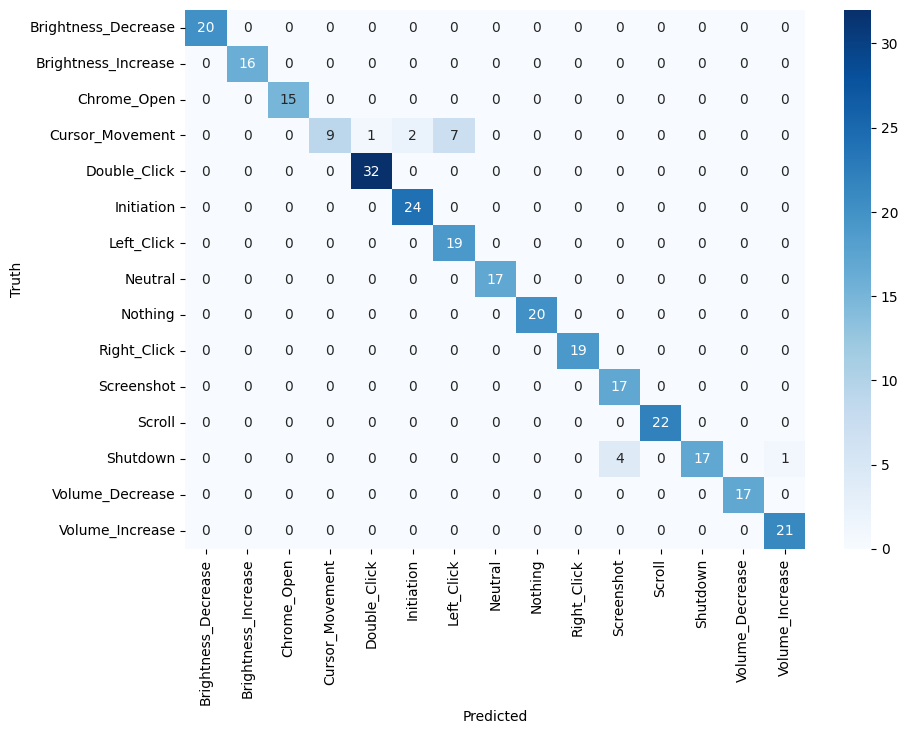

In [34]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix, roc_auc_score
from sklearn.preprocessing import LabelBinarizer
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Accuracy
accuracy = accuracy_score(y_true, y_pred)

# Precision, Recall, F1 Score
average = 'macro'  # or 'micro', 'weighted', depending on the problem
precision = precision_score(y_true, y_pred, average=average)
recall = recall_score(y_true, y_pred, average=average)
f1 = f1_score(y_true, y_pred, average=average)

# AUC-ROC for multiclass
lb = LabelBinarizer()
lb.fit(y_true)
y_true_lb = lb.transform(y_true)
y_pred_lb = lb.transform(y_pred)
auc_roc = roc_auc_score(y_true_lb, y_pred_lb, average=average, multi_class='ovr')

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)

# Print metrics
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")
print(f"AUC-ROC: {auc_roc}")

# Assuming class_names is a list of your class names in the order they were encoded
class_names = ['Brightness_Decrease', 'Brightness_Increase', 'Chrome_Open', 'Cursor_Movement', 'Double_Click', 'Initiation', 'Left_Click', 'Neutral', 'Nothing', 'Right_Click', 'Screenshot', 'Scroll', 'Shutdown', 'Volume_Decrease', 'Volume_Increase']
# class_names = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']

# class_names = ['A', 'B', 'Blank', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z']


# # Plot confusion matrix as a heatmap
# plt.figure(figsize=(10,7))
# sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_names, yticklabels=class_names)
# plt.xlabel('Predicted')
# plt.ylabel('Truth')
# plt.show()

# Plot confusion matrix as a heatmap
plt.figure(figsize=(10,7))
sns.heatmap(cm, annot=True, fmt='d',xticklabels=class_names, yticklabels=class_names, cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Truth')
plt.show()



In [30]:
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import LabelBinarizer

# Convert the true and predicted labels to a binary matrix
lb = LabelBinarizer()
lb.fit(y_true)
y_true_bin = lb.transform(y_true)
y_pred_bin = lb.transform(y_pred)

# Calculate the macro-averaged AUC-ROC
auc_roc_macro = roc_auc_score(y_true_bin, y_pred_bin, average='macro', multi_class='ovr')
print(f"Macro-Averaged AUC-ROC: {auc_roc_macro}")


Macro-Averaged AUC-ROC: 0.9140539620268436


In [35]:
model.save('/home/anon/MajorProject/Non_Git/Models/InceptionV3_FEB_14_Dataset_alpha_finetuned.keras')

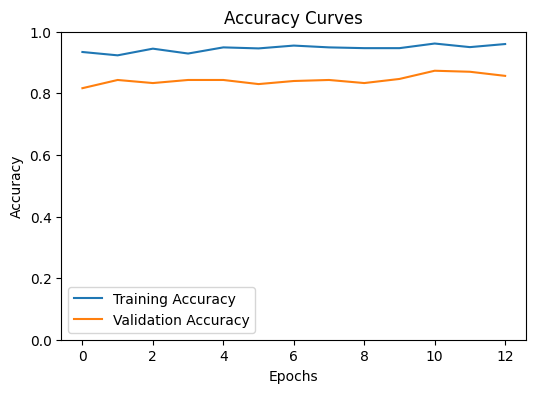

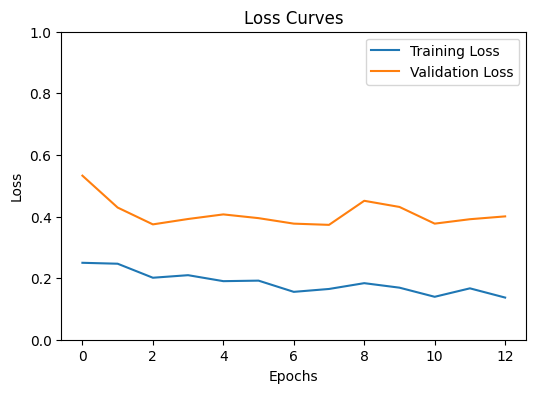

In [32]:
import matplotlib.pyplot as plt

# Plotting the Accuracy Curve
plt.figure(figsize=[6,4])
plt.plot(hist.history['accuracy'], linewidth=1.5)
plt.plot(hist.history['val_accuracy'], linewidth=1.5)
plt.legend(['Training Accuracy', 'Validation Accuracy'])
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy Curves')
plt.ylim([0, 1])  # Set the limits of the y-axis here
plt.show()

# Plotting the Loss Curve
plt.figure(figsize=[6,4])
plt.plot(hist.history['loss'], linewidth=1.5)
plt.plot(hist.history['val_loss'], linewidth=1.5)
plt.legend(['Training Loss', 'Validation Loss'])
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Curves')
plt.ylim([0, 1])  # Set the limits of the y-axis here
plt.show()
